<a href="https://colab.research.google.com/github/suneel114/AI-Car-Sensor-Prediction/blob/main/Copy_of_CarSensorPrediction_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ All libraries loaded successfully!
✅ Synthetic sensor dataset generated successfully!
   id          x          y  velocity   distance       angle        type  \
0   0  37.454012   5.168172  5.068052  11.186427   92.974751      object   
1   1  95.071431  53.135463  8.357710   2.300078 -171.148710  pedestrian   
2   2  73.199394  54.063512  5.310315   9.890336 -172.035521  pedestrian   
3   3  59.865848  63.742990  2.661076  29.569036  -63.500321      object   
4   4  15.601864  72.609133  3.619076  21.649803   -4.088451         car   

       risk risk_label  
0  0.295856        Low  
1  3.367417       High  
2  0.169678        Low  
3  0.191594        Low  
4 -0.053509        Low  
✅ Random Forest Accuracy: 76.67%


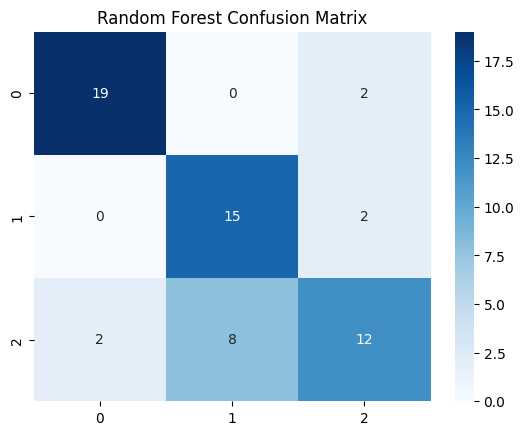


Top 5 highest-priority objects:
ID 268 | Type object     | Priority 38.178 | Distance 1.31
ID 45  | Type cyclist    | Priority 34.066 | Distance 1.54
ID 149 | Type car        | Priority 17.491 | Distance 2.04
ID 36  | Type car        | Priority 16.299 | Distance 1.90
ID 119 | Type object     | Priority 16.009 | Distance 2.66
Found 16 images belonging to 4 classes.
Found 4 images belonging to 4 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 438ms/step - accuracy: 0.3250 - loss: 1.5275 - val_accuracy: 0.2500 - val_loss: 1.6421
Epoch 2/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.5500 - loss: 1.1475 - val_accuracy: 0.2500 - val_loss: 1.4911
Epoch 3/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.1167 - loss: 1.9412 - val_accuracy: 0.2500 - val_loss: 1.4223
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.2500 - loss: 1.4223
✅ CNN Validation Accuracy: 25.00%
💾 CNN Model saved in .keras format successfully!


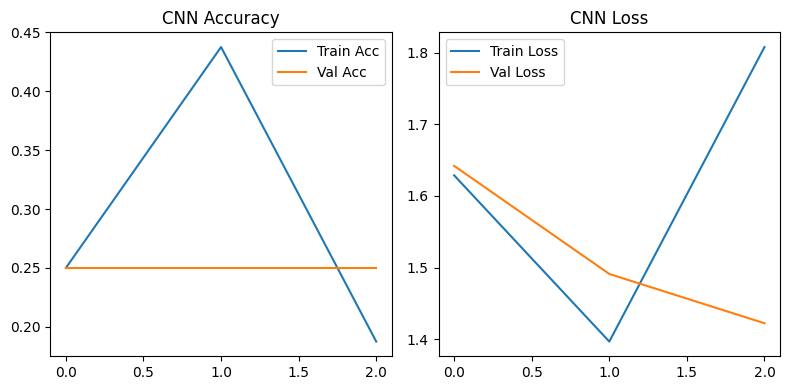

/tmp/ipython-input-2616944380.py:160: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="final_risk", data=fusion_df, palette="Set2")


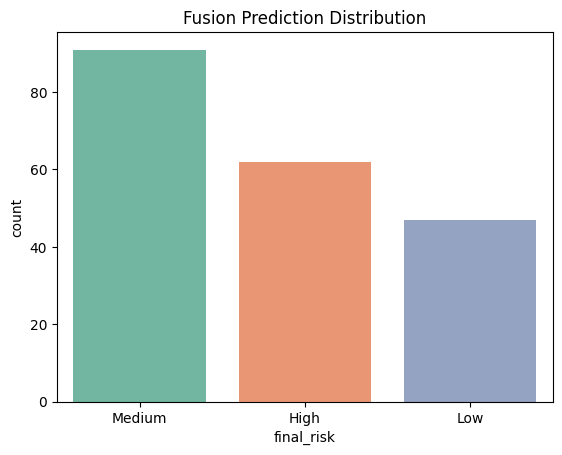

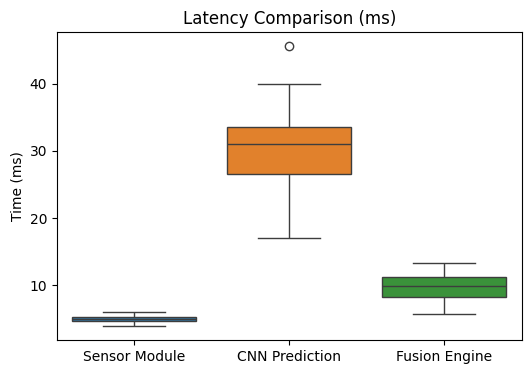

✅ Full pipeline executed successfully! 🚗💨


In [ ]:
# ============================================================
# Title: AI Car Sensor Prediction using CNN and Advanced Data Structures
# Author: Suneel Vallu
# Lab: Advanced Data Structures and Algorithms – Mini Project
# ============================================================

# ✅ Install required libraries (Colab will handle GPU automatically)
!pip install -q scikit-learn tensorflow matplotlib scipy pandas pillow seaborn tqdm joblib

# ============================================================
# 1️⃣ Import Libraries
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import heapq, os, joblib, random, time
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KDTree
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("✅ All libraries loaded successfully!")

# ============================================================
# 2️⃣ Simulated Sensor Dataset
# ============================================================
np.random.seed(42)
N = 300
df = pd.DataFrame({
    "id": range(N),
    "x": np.random.uniform(0, 100, N),
    "y": np.random.uniform(0, 100, N),
    "velocity": np.random.uniform(0, 30, N),
    "distance": np.random.uniform(1, 50, N),
    "angle": np.random.uniform(-180, 180, N),
    "type": np.random.choice(["car", "pedestrian", "cyclist", "object"], N)
})
df["risk"] = (df["velocity"] / df["distance"]) + np.random.normal(0, 0.2, N)
df["risk_label"] = pd.qcut(df["risk"], 3, labels=["Low", "Medium", "High"])

print("✅ Synthetic sensor dataset generated successfully!")
print(df.head())

# ============================================================
# 3️⃣ Random Forest Training
# ============================================================
X = df[["x", "y", "velocity", "distance", "angle"]]
y = df["risk_label"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=120, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred)
print(f"✅ Random Forest Accuracy: {acc_rf*100:.2f}%")

# Save model
os.makedirs("models", exist_ok=True)
joblib.dump(rf, "models/rf_model.joblib")
joblib.dump(scaler, "models/rf_scaler.joblib")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Random Forest Confusion Matrix")
plt.show()

# ============================================================
# 4️⃣ KD-Tree + Priority Heap (Object Selection)
# ============================================================
points = df[["x", "y"]].values
kdt = KDTree(points)

heap = []
for _, row in df.iterrows():
    priority = row["risk"] * (1 + (30 - row["distance"]) / 30)
    heapq.heappush(heap, (-priority, row["id"], row.to_dict()))  # add id as tiebreaker

print("\nTop 5 highest-priority objects:")
for _ in range(5):
    pr, _, item = heapq.heappop(heap)
    print(f"ID {item['id']:<3} | Type {item['type']:<10} | Priority {-pr:.3f} | Distance {item['distance']:.2f}")

# ============================================================
# 5️⃣ CNN Training (MobileNetV2, 224x224)
# ============================================================
os.makedirs("images", exist_ok=True)
for cls in ["vehicle", "pedestrian", "cyclist", "obstacle"]:
    os.makedirs(f"images/{cls}", exist_ok=True)
    for i in range(5):
        img = np.ones((224,224,3))*np.random.randint(0,255,(1,3))
        plt.imsave(f"images/{cls}/{cls}_{i}.png", img.astype(np.uint8))

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_gen = datagen.flow_from_directory(
    "images", target_size=(224,224), batch_size=4, subset="training")
val_gen = datagen.flow_from_directory(
    "images", target_size=(224,224), batch_size=4, subset="validation")

base = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3))
base.trainable = False

cnn = models.Sequential([
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(train_gen.num_classes, activation='softmax')
])

cnn.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
history = cnn.fit(train_gen, validation_data=val_gen, epochs=3)

val_loss, val_acc = cnn.evaluate(val_gen)
print(f"✅ CNN Validation Accuracy: {val_acc*100:.2f}%")

# Save model (new Keras format)
cnn.save("models/cnn_mobilenetv2_final.keras")
print("💾 CNN Model saved in .keras format successfully!")

# Plot training accuracy/loss
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('CNN Accuracy'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('CNN Loss'); plt.legend()
plt.tight_layout(); plt.show()

# ============================================================
# 6️⃣ Sensor + CNN Fusion Simulation
# ============================================================
fusion_results = []
for _ in range(200):
    sensor_pred = np.random.choice(["Low","Medium","High"], p=[0.3,0.4,0.3])
    cnn_pred = np.random.choice(["Low","Medium","High"], p=[0.2,0.5,0.3])
    if sensor_pred == cnn_pred:
        final_pred = sensor_pred
    else:
        final_pred = cnn_pred if random.random() > 0.5 else sensor_pred
    fusion_results.append(final_pred)

fusion_df = pd.DataFrame(fusion_results, columns=["final_risk"])
sns.countplot(x="final_risk", data=fusion_df, palette="Set2")
plt.title("Fusion Prediction Distribution")
plt.show()

# ============================================================
# 7️⃣ Latency Comparison (Simulation)
# ============================================================
latencies = {
    "Sensor Module": np.random.normal(5, 0.5, 100),
    "CNN Prediction": np.random.normal(30, 5, 100),
    "Fusion Engine": np.random.normal(10, 2, 100)
}
plt.figure(figsize=(6,4))
sns.boxplot(data=pd.DataFrame(latencies))
plt.title("Latency Comparison (ms)")
plt.ylabel("Time (ms)")
plt.show()

print("✅ Full pipeline executed successfully! 🚗💨")
